In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# Motivating GMM: Weakness of Kmeans

In [23]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


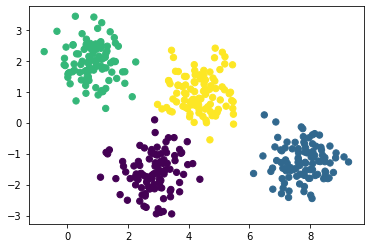

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

graph.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
graph.show()

##### Visualize cluster model and cut-off

In [25]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot input data
    ax = ax or graph.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # Plot the representation of the Kmeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(graph.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

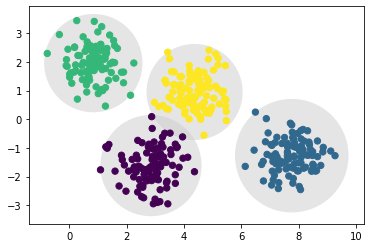

In [26]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

For Kmeans, clusters HAVE to be circular

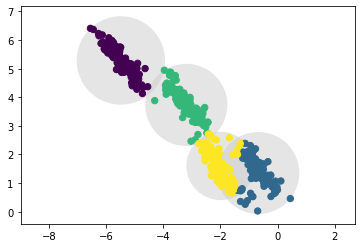

In [28]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

So disadvantages of kmeans:
- Lack of flexibility in cluster shape
- Lack of propabilistic cluster assignment

# Generalizing E–M: Gaussian Mixture Models

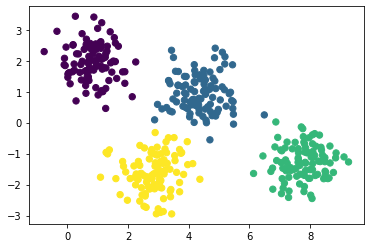

In [29]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

graph.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
graph.show()

In [30]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.531 0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


##### Visualize uncertainty

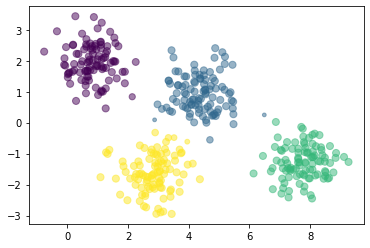

In [32]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences

graph.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, alpha=0.5)
graph.show()

A GMM is similar to kmeans, uses an expectation-maximization to:
- Choose starting guesses for location and shape
- Repeat until converged:
    - E-step: for each point, find weights that indicate probability of membership in each cluster
    - M-step: for each cluster, update location, normalization, and shape based on all data points, using the weights

In [36]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or graph.gca()
    
    # convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or graph.gca()
    
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)        

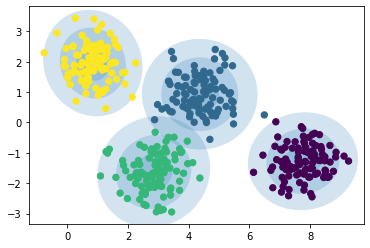

In [37]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

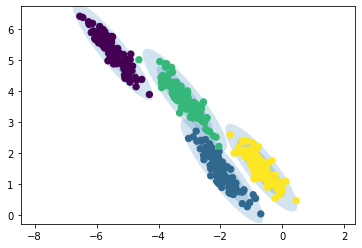

In [39]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## Choosing the Covariance type

- Spherical: will act like kmeans
- full: will make elipses
- diag: elipse, but constrained to align to axes

# GMM as Density Estimation

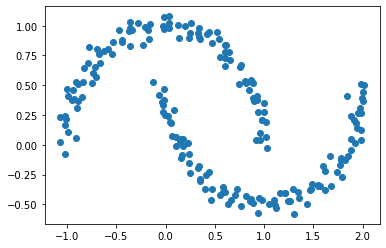

In [40]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

graph.scatter(Xmoon[:, 0], Xmoon[:, 1])
graph.show()

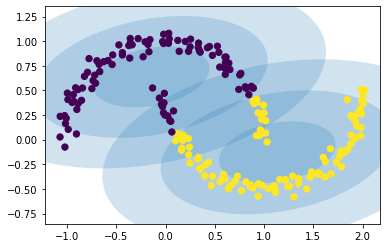

In [42]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

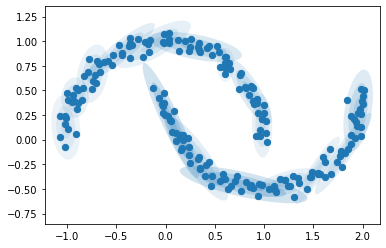

In [43]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Allows us to generate new random data distributed similarly to our original data

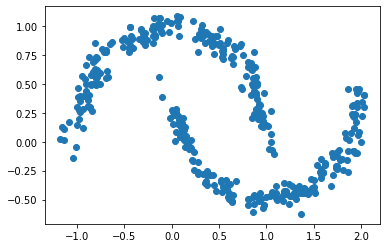

In [57]:
Xnew = gmm16.sample(400)

graph.scatter(Xnew[0][:, 0], Xnew[0][:, 1])
graph.show()

## How many components

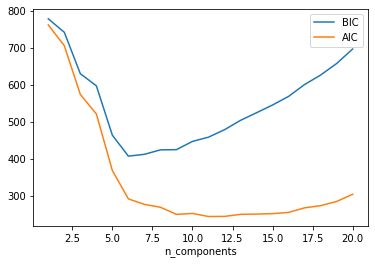

In [59]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

graph.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
graph.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
graph.legend(loc='best')
graph.xlabel('n_components')
graph.show()

# Use GMM mainly as a density estimator, and only when needed with simplae dataset, use for clustering

## Example: GMM for generating new data

In [60]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

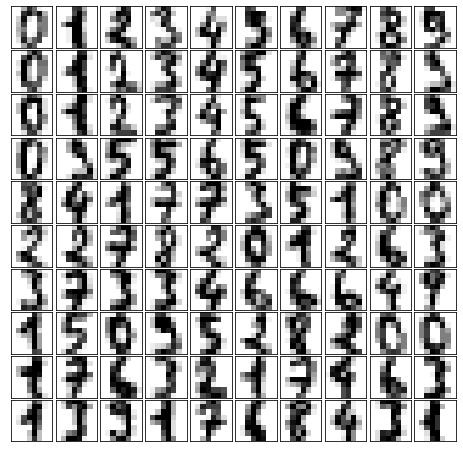

In [64]:
def plot_digits(data):
    fig, ax = graph.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

plot_digits(digits.data)

In [65]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

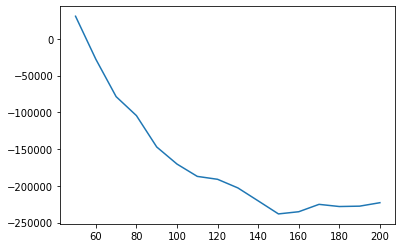

In [67]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]

graph.plot(n_components, aics)
graph.show()

In [69]:
gmm = GaussianMixture(150, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [71]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

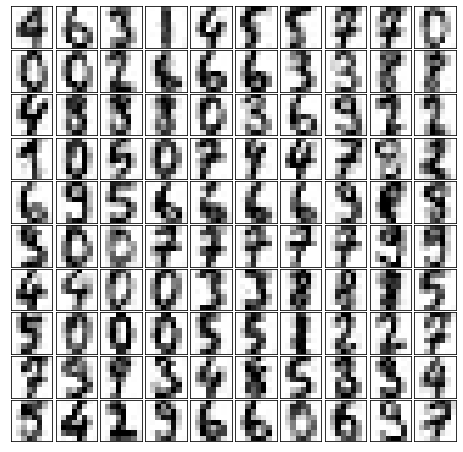

In [72]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)